<a href="https://colab.research.google.com/github/rahulsinghshah/ml_models/blob/main/foodvision101_classification_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#0. Tools

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, callbacks, mixed_precision

In [2]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-7f9a74e5-5194-7c8a-3b27-911c7f91dca4)


In [36]:
!wget https://raw.githubusercontent.com/rahulsinghshah/Extras/refs/heads/main/helper_tools.py

--2025-07-28 02:21:39--  https://raw.githubusercontent.com/rahulsinghshah/Extras/refs/heads/main/helper_tools.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9420 (9.2K) [text/plain]
Saving to: ‘helper_tools.py’

helper_tools.py     100%[===================>]   9.20K  --.-KB/s    in 0s      

2025-07-28 02:21:39 (107 MB/s) - ‘helper_tools.py’ saved [9420/9420]



In [4]:
from helper_tools import create_tensorboard_callback, plot_loss_curves, compare_historys

# 1. Use TensorFlow dataset to download data

In [5]:
#Get TensorFlow dataset
import tensorflow_datasets as tfds

#get all available datasets in tfds
dataset_list = tfds.list_builders()

#check for food101 dataset
print("food101" in dataset_list)

True


In [6]:
#load the data
(train_data, test_data), df_info = tfds.load(name = "food101",
                                             split = ["train", "validation"],
                                             shuffle_files = True,
                                             as_supervised = True, #return data in tuple format (data, label)
                                             with_info = True #gives meta data
                                             )

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.0CAM7L_2.0.0/food101-train.tfrecord*...:   0%|         …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.0CAM7L_2.0.0/food101-validation.tfrecord*...:   0%|    …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


## Exploring the Food101 data
* class names
* The shape of our input data (image tensors)
* The datatype of our input data
* What the labels of our input data look like (e.g. one-hot encoded versus label-encoded)
* Do the labels match up with the class names?

In [7]:
df_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [8]:
class_names = df_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [9]:
#Take one sample from training data
one_sample = train_data.take(1) #format (image_tensor, label)
one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

Let's loop through our sample and get some information

In [10]:
for image, label in one_sample:
  print(f"""
  Image shape: {image.shape}
  Image datatype: {image.dtype}
  Target class form Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (512, 512, 3)
  Image datatype: <dtype: 'uint8'>
  Target class form Food101 (tensor form): 8
  Class name (str form): bread_pudding
        


In [11]:
# What does an image tensor from TFDS's Food101 look like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[18,  6,  8],
        [18,  6,  8],
        [18,  6,  8],
        ...,
        [30, 15, 22],
        [29, 14, 21],
        [26, 11, 18]],

       [[22, 10, 12],
        [21,  9, 11],
        [20,  8, 10],
        ...,
        [35, 20, 27],
        [31, 16, 23],
        [26, 11, 18]],

       [[23, 13, 14],
        [21, 11, 12],
        [19,  9, 10],
        ...,
        [39, 26, 33],
        [36, 21, 28],
        [30, 15, 22]],

       ...,

       [[15,  4,  8],
        [15,  4,  8],
        [14,  5, 10],
        ...,
        [41,  9, 10],
        [39,  7,  8],
        [36,  4,  5]],

       [[16,  5,  9],
        [16,  5,  9],
        [16,  5, 11],
        ...,
        [42, 12, 12],
        [39,  9,  9],
        [35,  5,  5]],

       [[15,  4,  8],
        [15,  4,  8],
        [16,  5, 11],
        ...,
        [41, 11, 11],
        [39,  9,  9],
        [35,  5,  5]]], dtype=uint8)>

In [12]:
# What are the min and max values?
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

## Plot an image from dataset

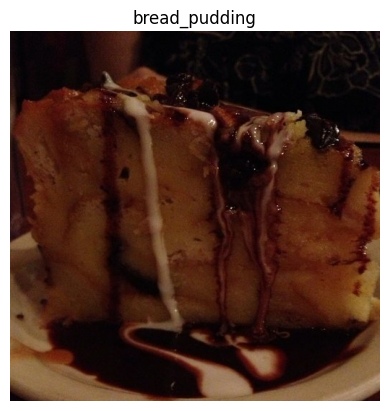

In [13]:
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);

# 2. Start building the model (Feature Extraction)

##Create preprocessing function
we'll create a preprocess_img() function which:

* Resizes an input image tensor to a specified size using `tf.image.resize()`
* Converts an input image tensor's current datatype to `tf.float32` using `tf.cast()`

In [14]:
def preprocess_img(image, label, img_shape=224):
  """
    Converts image datatype from 'uint8' -> 'float32' and reshapes image to
    [img_shape, img_shape, color_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape])
  # image = image/255. #not required for EfficientNet
  return tf.cast(image, tf.float32), label

In [15]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[18  6  8]
  [18  6  8]
  [18  6  8]
  ...
  [30 15 22]
  [29 14 21]
  [26 11 18]]

 [[22 10 12]
  [21  9 11]
  [20  8 10]
  ...
  [35 20 27]
  [31 16 23]
  [26 11 18]]]...,
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[20.158163   8.158163  10.158163 ]
  [18.42347    7.6173472  9.020408 ]
  [15.010203   6.423469   9.285714 ]
  ...
  [26.285824  15.714351  23.07156  ]
  [31.091867  17.285728  24.285728 ]
  [28.754953  13.754952  20.754953 ]]

 [[18.92857    8.928571   9.928571 ]
  [16.214285   7.0765305  8.07653  ]
  [14.739796   8.571429  10.627552 ]
  ...
  [26.444029  15.872557  21.658293 ]
  [39.86226   26.862259  33.86226  ]
  [39.49479   24.494787  31.494787 ]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


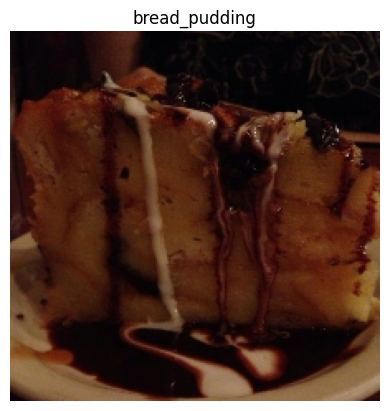

In [16]:
# We can still plot our preprocessed image as long as we divide by 255 (for matplotlib capatibility)
plt.imshow(preprocessed_img/255.)
plt.title(class_names[label])
plt.axis(False);

##Batch & prepare datasets & Setup mixed precision training

In [17]:
#CONFIG
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 3
NUM_CLASSES = len(class_names)
CHECKPOINT_PATH = "model_checkpoints/efficientnetb0_best.weights.h5"
MIXED_PRECISION = True

#SET MIXED PRECISION (if supported)
if MIXED_PRECISION:
    mixed_precision.set_global_policy("mixed_float16")

#DATASET PIPELINES
def prepare_dataset(ds, is_train=True):
    ds = ds.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
    if is_train:
        ds = ds.shuffle(1000)
    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_data = prepare_dataset(train_data, is_train=True)
test_data = prepare_dataset(test_data, is_train=False)

In [18]:
#CALLBACKS
tensorboard_cb = create_tensorboard_callback("training_logs", "efficientnetb0_101_classes_feature_extract")
checkpoint_cb = callbacks.ModelCheckpoint(
    CHECKPOINT_PATH,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True,
    verbose=0
)

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_feature_extract/20250728-011952


##Model Creation

In [19]:
#Function for MODEL CREATION
def build_model(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=NUM_CLASSES):
    base_model = tf.keras.applications.EfficientNetB0(include_top=False)
    base_model.trainable = False  # Feature extraction only

    inputs = layers.Input(shape=input_shape, name="input_layer")
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D(name="global_avg_pool")(x)
    x = layers.Dense(num_classes)(x)
    outputs = layers.Activation("softmax", dtype="float32", name="softmax")(x)

    model = models.Model(inputs, outputs)
    return model

In [20]:
model = build_model()

# MODEL COMPILATION
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [21]:
#MODEL TRAINING
history = model.fit(
    train_data,
    epochs=EPOCHS,
    validation_data=test_data,
    validation_steps=int(0.15 * len(test_data)),
    callbacks=[tensorboard_cb, checkpoint_cb]
)

Epoch 1/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 195s 70ms/step - accuracy: 0.4776 - loss: 2.2807 - val_accuracy: 0.6952 - val_loss: 1.1294
Epoch 2/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 174s 65ms/step - accuracy: 0.6690 - loss: 1.2785 - val_accuracy: 0.7127 - val_loss: 1.0430
Epoch 3/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 149s 62ms/step - accuracy: 0.7034 - loss: 1.1361 - val_accuracy: 0.7243 - val_loss: 0.9923


In [22]:
#MODEL EVALUATION
results = model.evaluate(test_data)
print("Test Accuracy:", results[1])

790/790 ━━━━━━━━━━━━━━━━━━━━ 51s 65ms/step - accuracy: 0.7229 - loss: 1.0043
Test Accuracy: 0.7276039719581604


#3. Fine-Tuning

In [23]:
# Load the saved weights (feature extraction)
model.load_weights(CHECKPOINT_PATH)

# Evaluate feature extraction model (optional check)
results_feature_extract = model.evaluate(test_data)

790/790 ━━━━━━━━━━━━━━━━━━━━ 44s 56ms/step - accuracy: 0.7228 - loss: 1.0040


In [24]:
#Fine-Tuning
model.layers[1].trainable = True  # Unfreeze base model

# Check dtype policy of first few layers (optional debug)
for layer in model.layers[1].layers[:20]:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <DTypePolicy "mixed_float16">
rescaling True float32 <DTypePolicy "mixed_float16">
normalization True float32 <DTypePolicy "mixed_float16">
rescaling_1 True float32 <DTypePolicy "mixed_float16">
stem_conv_pad True float32 <DTypePolicy "mixed_float16">
stem_conv True float32 <DTypePolicy "mixed_float16">
stem_bn True float32 <DTypePolicy "mixed_float16">
stem_activation True float32 <DTypePolicy "mixed_float16">
block1a_dwconv True float32 <DTypePolicy "mixed_float16">
block1a_bn True float32 <DTypePolicy "mixed_float16">
block1a_activation True float32 <DTypePolicy "mixed_float16">
block1a_se_squeeze True float32 <DTypePolicy "mixed_float16">
block1a_se_reshape True float32 <DTypePolicy "mixed_float16">
block1a_se_reduce True float32 <DTypePolicy "mixed_float16">
block1a_se_expand True float32 <DTypePolicy "mixed_float16">
block1a_se_excite True float32 <DTypePolicy "mixed_float16">
block1a_project_conv True float32 <DTypePolicy "mixed_float16">
block1a_project

In [25]:
# Re-compile with a lower learning rate for fine-tuning
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=["accuracy"]
)

In [26]:
#Setup callbacks (best-only saving, early stopping, LR reducer)
fine_tune_checkpoint_path = "fine_tune_best_model.weights.h5"

model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    fine_tune_checkpoint_path,
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

reduce_lr_cb = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=2,
    verbose=1,
    min_lr=1e-7
)

In [27]:
history_fine_tune = model.fit(
    train_data,
    epochs=100,
    validation_data=test_data,
    validation_steps=int(0.15 * len(test_data)),
    callbacks=[
        create_tensorboard_callback("training_logs", "efficientb0_fine_tuning"),
        model_checkpoint_cb,
        early_stopping_cb,
        reduce_lr_cb
    ]
)

Saving TensorBoard log files to: training_logs/efficientb0_fine_tuning/20250728-013124
Epoch 1/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.6269 - loss: 1.4743
Epoch 1: val_loss improved from inf to 0.72243, saving model to fine_tune_best_model.weights.h5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 353s 107ms/step - accuracy: 0.6269 - loss: 1.4742 - val_accuracy: 0.7993 - val_loss: 0.7224 - learning_rate: 1.0000e-04
Epoch 2/100
2367/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.7960 - loss: 0.7594
Epoch 2: val_loss improved from 0.72243 to 0.66025, saving model to fine_tune_best_model.weights.h5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 200s 83ms/step - accuracy: 0.7960 - loss: 0.7594 - val_accuracy: 0.8162 - val_loss: 0.6602 - learning_rate: 1.0000e-04
Epoch 3/100
2367/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.8540 - loss: 0.5443
Epoch 3: val_loss improved from 0.66025 to 0.63355, saving model to fine_tune_best_model.weights.h5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 200s 83ms/step

In [28]:
# Load best fine-tuned weights
model.load_weights(fine_tune_checkpoint_path)

# Final evaluation
final_results = model.evaluate(test_data)
print("Final Test Accuracy:", final_results[1])

790/790 ━━━━━━━━━━━━━━━━━━━━ 54s 68ms/step - accuracy: 0.8377 - loss: 0.6308
Final Test Accuracy: 0.8343366384506226


#4. Evaluating our models predictions

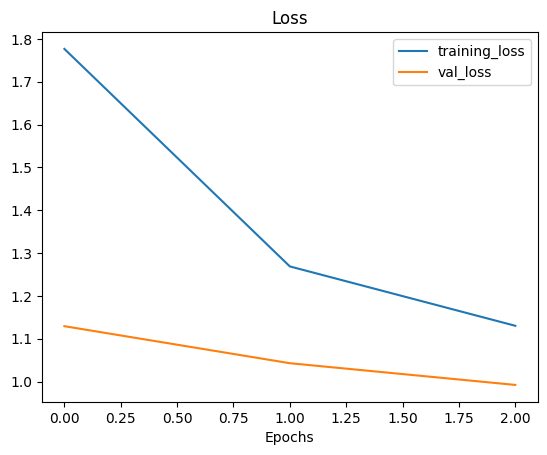

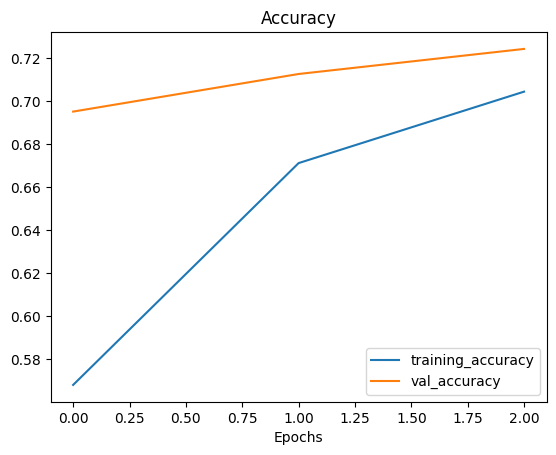

In [29]:
#loss and accuracy of Feature extractor model
from helper_tools import plot_loss_curves

plot_loss_curves(history)

3
13
[0.5681188106536865, 0.6712343096733093, 0.7044488191604614, 0.6934521198272705, 0.8030626773834229, 0.8580858111381531, 0.8990626931190491, 0.9272739291191101, 0.9488052725791931, 0.9735841751098633, 0.9788250923156738, 0.9812409281730652, 0.9845280647277832]


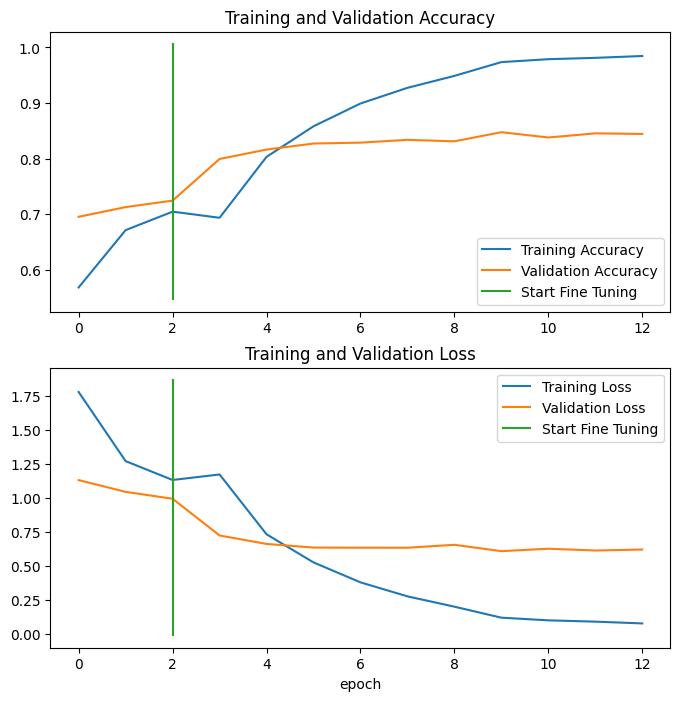

In [30]:
#loss and accuracy after fine tune

compare_historys(history, history_fine_tune, initial_epochs=3)

**Let's make Predictions and save the model**

In [31]:
# 1. Get model predictions (logits or probabilities)
y_pred_probs = model.predict(test_data)

# 2. Convert probabilities to predicted class labels (highest prob = chosen class)
y_pred = np.argmax(y_pred_probs, axis=1)

# 3. Get true labels (y_true) from test_data
# Correctly unbatch and get true labels
y_true = np.array([label.numpy() for _, label in test_data.unbatch()])

790/790 ━━━━━━━━━━━━━━━━━━━━ 62s 69ms/step


In [ ]:
# Save model locally
model.save("efficientnetb0_fine_tuned_101_classes_model.h5")